In [38]:
from monai.utils import first, set_determinism
from monai.transforms import(
    Compose,
    EnsureChannelFirstd,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset

import torch
import matplotlib.pyplot as plt

import os
from glob import glob
import numpy as np

from monai.inferers import sliding_window_inference

In [39]:
in_dir = 'dataset/opennero/braindata'
model_dir = 'dataset/result_model'

In [40]:
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_test.npy'))

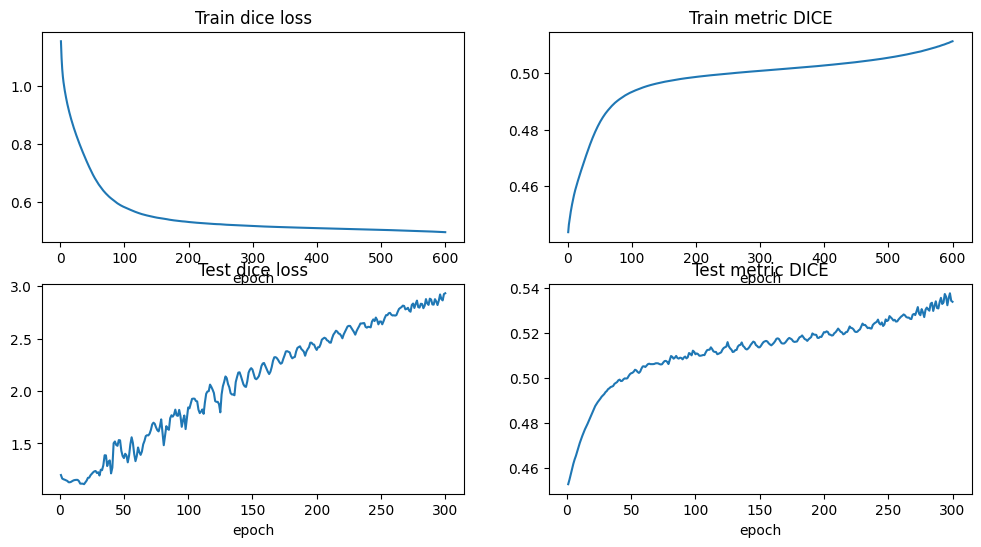

In [41]:
plt.figure("Results 25 june", (12, 6))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("Test dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Test metric DICE")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

In [42]:
base_data_path="./dataset/opennero/braindata"
mask_base_path="./dataset/opennero/binary_epvs_groundtruth/mask"

set_determinism(seed=999999)
image_pattern = "**/*_T2w_brain.nii.gz"
found_images = glob(os.path.join(base_data_path, image_pattern), recursive=True)

data = []
for img_path in found_images:
    subject_id = os.path.basename(os.path.dirname(os.path.dirname(img_path)))
    mask_path = os.path.join(mask_base_path, subject_id, f"{subject_id}_desc-mask_PVS.nii.gz")

    if os.path.exists(mask_path):
        data.append({"image": img_path, "label": mask_path})
    else:
        print(f"Warning: Mask not found for {subject_id}")

if len(data) == 0:
    raise RuntimeError("No image-mask pairs found. Check your paths!")

print(f"Loaded {len(data)} image-mask pairs.")


# Split train/test
cache = False
train_size = int(0.8 * len(data))
train_data, val_data = data[:train_size], data[train_size:]

Loaded 91 image-mask pairs.


In [43]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(0.8, 0.8, 0.8), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS", labels=None),
        ScaleIntensityRanged(keys=["image"], a_min=200, a_max=750, b_min=0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Resized(keys=["image", "label"], spatial_size=[208, 256, 320]),
        ToTensord(keys=["image", "label"]),
    ]
)

In [44]:
test_ds = Dataset(data=val_data, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

In [45]:
device = torch.device("cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [46]:
model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))
model.eval()

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
sw_batch_size = 4
roi_size = (128, 128, 64)
with torch.no_grad():
    test_patient = first(test_loader)
    t_volume = test_patient['vol']
    #t_segmentation = test_patient['seg']

    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.53

    for i in range(32):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0)
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])
        plt.show()